In [ ]:
!pip install tf-keras-vis
!pip install pyyaml h5py
!pip install tensorflow_addons
!pip install lime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
import math, os, re, warnings, random
from sklearn.utils import class_weight
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

In [ ]:
LEARNING_RATE = 3e-5
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.InceptionV3(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
    x = tf.keras.layers.Dropout(.25)(base_model.output) 
    x = tf.keras.layers.Dense(N_CLASSES, activation='sigmoid', name='output')(x)

    model = tf.keras.Model(input_image, x)
    for layer in base_model.layers:
        if 'bn' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy',tfa.metrics.F1Score(num_classes=2, average='weighted')])
    
    return model

In [ ]:
fold=2
model = model_fn((None,None,3),2)
model_path = f'/content/drive/MyDrive/Colab Notebooks/SaveLeukemiaModel/OnlyWeightsWithh5/model_{fold}.h5'
model.load_weights(model_path)
# model.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# GradCAM

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
GCS_PATH='/content/'
# Image titles
image_titles = ['Cell_1', 'Cell_2', 'Cell_3']

img1 = load_img(GCS_PATH + '/UID_11_12_3_all.bmp', target_size=(299, 299))
img2 = load_img(GCS_PATH + '/UID_H12_12_6_hem.bmp', target_size=(299, 299))
img3 = load_img(GCS_PATH + '/UID_H12_13_4_hem.bmp', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# img1 = np.array(img1)
X = tf.keras.applications.inception_v3.preprocess_input(images)


In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([0,1,1])

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam1 = gradcam(score, X, penultimate_layer=-1)


# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam2 = gradcam(score,
              X,
              penultimate_layer=-1)


# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam3 = scorecam(score, X, penultimate_layer=-1)



18/18 [==============================] - 3s 120ms/step


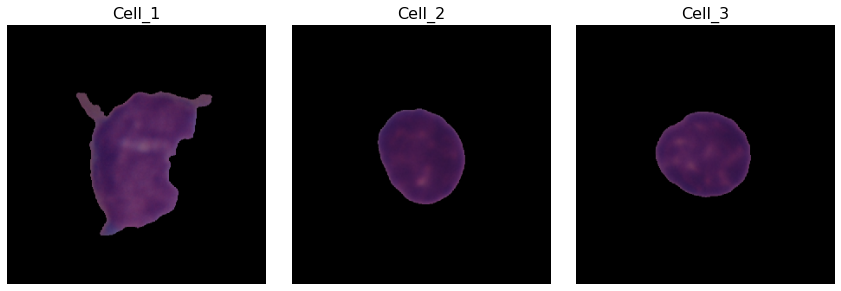

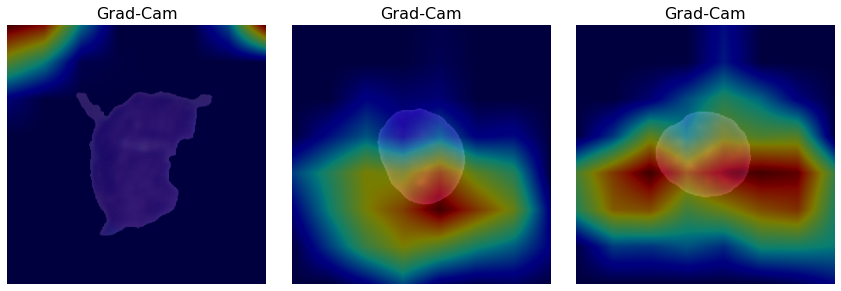

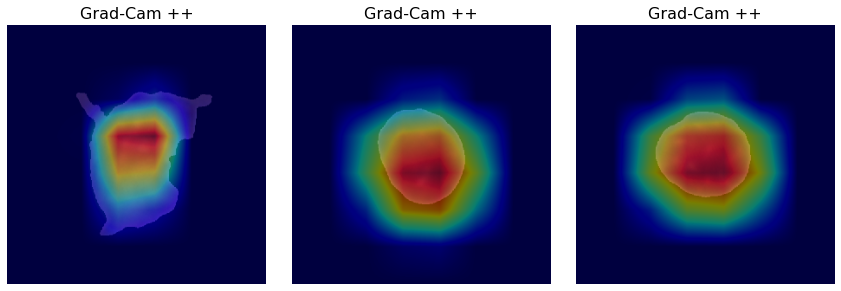

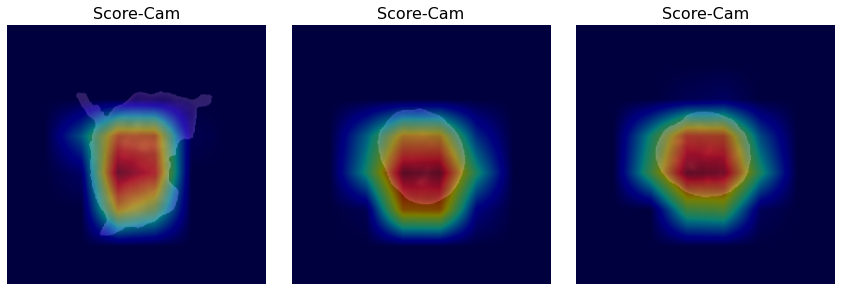

In [ ]:
# Rendering Original Images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Rendering Grad-Cam Images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam1[i])[..., :3] * 255)
    ax[i].set_title('Grad-Cam', fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Rendering Grad-Cam ++ Images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam2[i])[..., :3] * 255)
    ax[i].set_title('Grad-Cam ++', fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()

# Rendering Score-Cam Images
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam3[i])[..., :3] * 255)
    ax[i].set_title("Score-Cam", fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Lime

three false cases

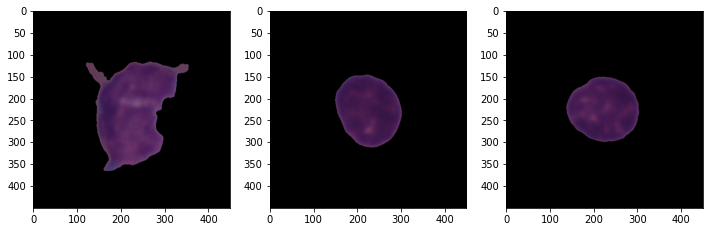

In [ ]:
import PIL
from PIL import Image

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

im1 = Image.open('/content/UID_11_12_3_all.bmp')
p1 = np.array(im1)
ax[0].imshow(p1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

im2 = Image.open('/content/UID_H12_12_6_hem.bmp')
p2 = np.array(im2)
ax[1].imshow(p2)
p2 = np.expand_dims(p2, axis=0)

im3 = Image.open('/content/UID_H12_13_4_hem.bmp')
p3 = np.array(im3)
ax[2].imshow(p3)
p3 = np.expand_dims(p3, axis=0)

prediction on 1st image

1/1 [==============================] - 2s 2s/step
Prediction is Hem
Prediction Confidence Percentage is:  32.986703515052795


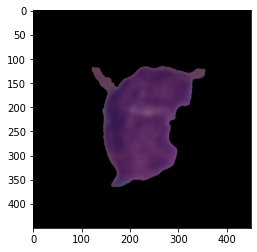

In [ ]:
preds = model.predict(p1)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im1);

prediction on 2nd image

1/1 [==============================] - 0s 54ms/step
The Prediction of the sample is: It Is ALL
Prediction Confidence Percentage is:  48.83720278739929


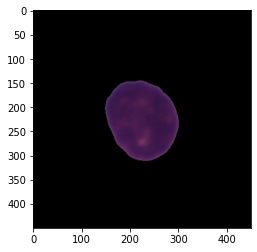

In [ ]:
preds = model.predict(p2)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im2);

prediction on 3rd image

1/1 [==============================] - 0s 34ms/step
The Prediction of the sample is: It Is ALL
Prediction Confidence Percentage is:  41.062262654304504


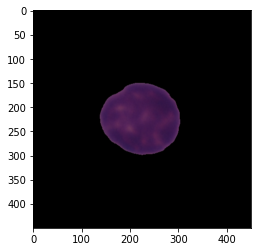

In [ ]:
preds = model.predict(p3)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im3);

lime for 1st image

/usr/local/lib/python3.8/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


91


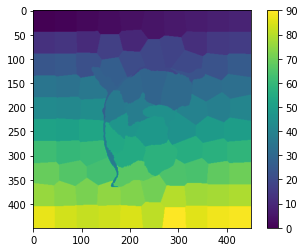

In [ ]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
 
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(im1)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar();

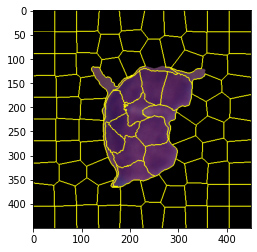

In [ ]:
plt.imshow(mark_boundaries(np.array(im1), segments));

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(im1), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

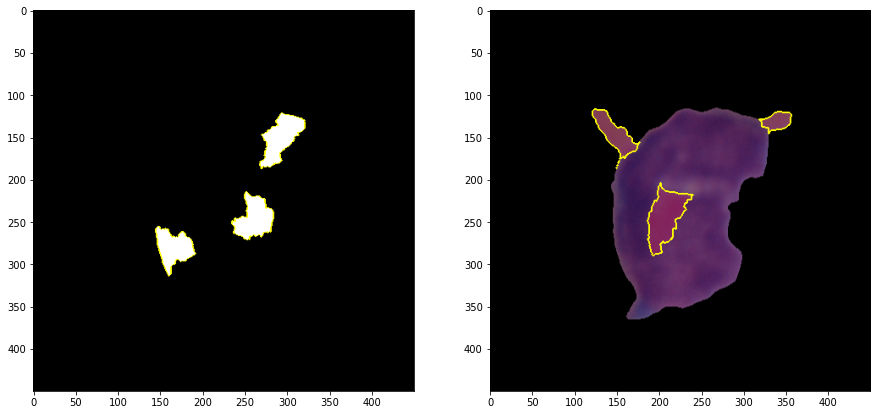

In [ ]:
from skimage.segmentation import mark_boundaries


temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2));


lime for 2nd Image

/usr/local/lib/python3.8/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


95


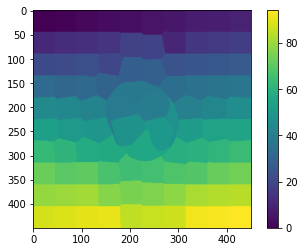

In [ ]:
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(im2)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar();

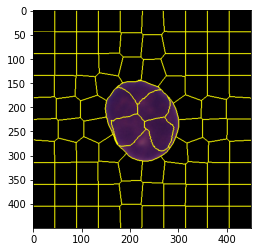

In [ ]:
plt.imshow(mark_boundaries(np.array(im2), segments));

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(im2), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

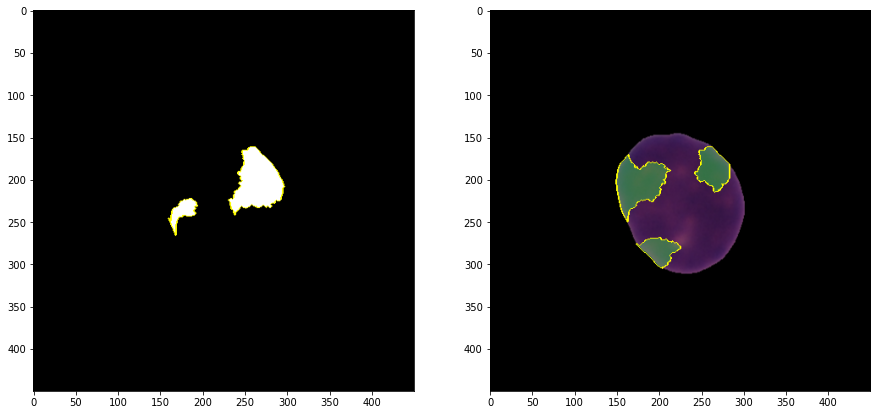

In [ ]:
from skimage.segmentation import mark_boundaries


temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2));


lime for 3rd Image

/usr/local/lib/python3.8/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


95


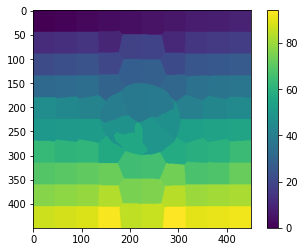

In [ ]:
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(im3)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar();

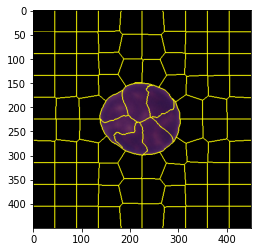

In [ ]:
plt.imshow(mark_boundaries(np.array(im3), segments));

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(im3), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

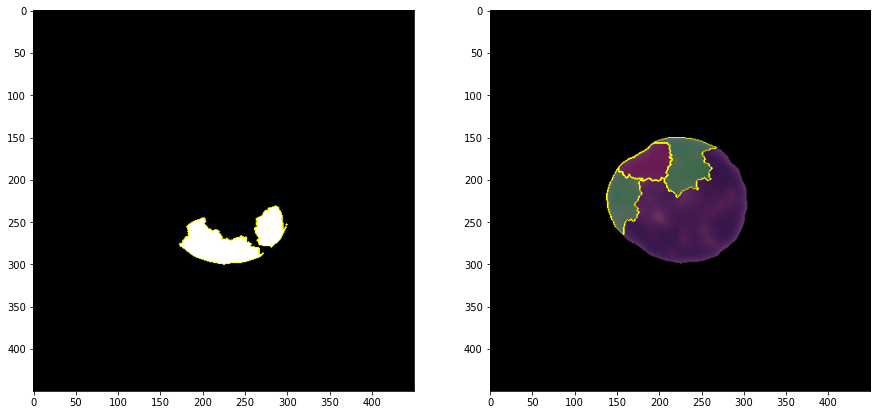

In [ ]:
from skimage.segmentation import mark_boundaries


temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2));
